In [1]:
#!/usr/bin/env python3

# Copyright (c) Facebook, Inc. and its affiliates.
# This source code is licensed under the MIT license found in the
# LICENSE file in the root directory of this source tree.

import argparse
import os
import random
import sys
import time
from math import pi

import numpy as np
import matplotlib.pyplot as plt
import orbslam2
import PIL
import cv2
import requests
import torch
import torch.nn.functional as F

import habitat
from habitat.config.default import get_config
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat_baselines.config.default import get_config as cfg_baseline
from habitat_baselines.slambased.mappers import DirectDepthMapper
from habitat_baselines.slambased.monodepth import MonoDepthEstimator
from habitat_baselines.slambased.path_planners import DifferentiableStarPlanner
from habitat_baselines.slambased.reprojection import (
    get_direction,
    get_distance,
    habitat_goalpos_to_mapgoal_pos,
    homogenize_p,
    planned_path2tps,
    project_tps_into_worldmap,
    angle_to_pi_2_minus_pi_2 as norm_ang,
)
from habitat_baselines.slambased.utils import generate_2dgrid

GOAL_SENSOR_UUID = "pointgoal_with_gps_compass"
#GOAL_SENSOR_UUID = "objectgoal"


Bad key "text.kerning_factor" on line 4 in
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8

In [2]:
def download(url, filename):
    with open(filename, "wb") as f:
        response = requests.get(url, stream=True)
        total = response.headers.get("content-length")
        if total is None:
            f.write(response.content)
        else:
            downloaded = 0
            total = int(total)
            for data in response.iter_content(
                chunk_size=max(int(total / 1000), 1024 * 1024)
            ):
                downloaded += len(data)
                f.write(data)
                done = int(50 * downloaded / total)
                sys.stdout.write(
                    "\r[{}{}]".format("█" * done, "." * (50 - done))
                )
                sys.stdout.flush()
    sys.stdout.write("\n")


def ResizePIL2(np_img, size=256):
    im1 = PIL.Image.fromarray(np_img)
    return np.array(im1.resize((size, size)))


def make_good_config_for_orbslam2(config):
    config.SIMULATOR.AGENT_0.SENSORS = ["RGB_SENSOR", "DEPTH_SENSOR"]
    config.SIMULATOR.RGB_SENSOR.WIDTH = 640
    config.SIMULATOR.RGB_SENSOR.HEIGHT = 480
    config.SIMULATOR.DEPTH_SENSOR.WIDTH = 640
    config.SIMULATOR.DEPTH_SENSOR.HEIGHT = 480
    config.ORBSLAM2.CAMERA_HEIGHT = config.SIMULATOR.DEPTH_SENSOR.POSITION[
        1
    ]
    config.ORBSLAM2.H_OBSTACLE_MIN = (
        0.3 * config.ORBSLAM2.CAMERA_HEIGHT
    )
    config.ORBSLAM2.H_OBSTACLE_MAX = (
        1.0 * config.ORBSLAM2.CAMERA_HEIGHT
    )
    config.ORBSLAM2.MIN_PTS_IN_OBSTACLE = (
        config.SIMULATOR.DEPTH_SENSOR.WIDTH / 2.0
    )
    return


from PIL import Image
from examples.habitat_sim_py.utils.common import d3_40_colors_rgb
import numpy as np

def display_sample(rgb_obs, semantic_obs, depth_obs):
    rgb_img = Image.fromarray(rgb_obs, mode="RGB")
    
    semantic_img = Image.new("P", (semantic_obs.shape[1], semantic_obs.shape[0]))
    semantic_img.putpalette(d3_40_colors_rgb.flatten())
    semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
    semantic_img = semantic_img.convert("RGBA")
    
    depth_img = Image.fromarray((depth_obs * 255).astype(np.uint8), mode="L")

    arr = [rgb_img, semantic_img, depth_img]
    
    titles = ['rgb', 'semantic', 'depth']
    plt.figure(figsize=(12 ,8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i+1)
        ax.axis('off')
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show()

In [3]:
class RandomAgent(object):
    r"""Simplest agent, which returns random actions,
    until reach the goal
    """

    def __init__(self, config):
        super(RandomAgent, self).__init__()
        self.num_actions = config.NUM_ACTIONS
        self.dist_threshold_to_stop = config.DIST_TO_STOP
        self.reset()
        return

    def reset(self):
        self.steps = 0
        return

    def update_internal_state(self, habitat_observation):
        self.obs = habitat_observation
        self.steps += 1
        return

    def is_goal_reached(self):
        dist = self.obs[GOAL_SENSOR_UUID][0]
        return dist <= self.dist_threshold_to_stop

    def act(self, habitat_observation=None, random_prob=1.0):
        self.update_internal_state(habitat_observation)
        # Act
        # Check if we are done
        if self.is_goal_reached():
            action = HabitatSimActions.STOP
        else:
            action = random.randint(0, self.num_actions - 1)
        return {"action": action}


class BlindAgent(RandomAgent):
    def __init__(self, config):
        super(BlindAgent, self).__init__()
        self.pos_th = config.DIST_TO_STOP
        self.angle_th = config.ANGLE_TH
        self.reset()
        return

    def decide_what_to_do(self):
        distance_to_goal = self.obs[GOAL_SENSOR_UUID][0]
        angle_to_goal = norm_ang(np.array(self.obs[GOAL_SENSOR_UUID][1]))
        command = HabitatSimActions.STOP
        if distance_to_goal <= self.pos_th:
            return command
        if abs(angle_to_goal) < self.angle_th:
            command = HabitatSimActions.MOVE_FORWARD
        else:
            if (angle_to_goal > 0) and (angle_to_goal < pi):
                command = HabitatSimActions.TURN_LEFT
            elif angle_to_goal > pi:
                command = HabitatSimActions.TURN_RIGHT
            elif (angle_to_goal < 0) and (angle_to_goal > -pi):
                command = HabitatSimActions.TURN_RIGHT
            else:
                command = HabitatSimActions.TURN_LEFT

        return command

    def act(self, habitat_observation=None, random_prob=0.1):
        self.update_internal_state(habitat_observation)
        # Act
        if self.is_goal_reached():
            return HabitatSimActions.STOP
        command = self.decide_what_to_do()
        random_action = random.randint(0, self.num_actions - 1)
        act_randomly = np.random.uniform(0, 1, 1) < random_prob
        if act_randomly:
            action = random_action
        else:
            action = command
        return {"action": action}

In [4]:
class ORBSLAM2Agent(RandomAgent):
    def __init__(self, config, device=torch.device("cuda:0"), print_attrs=False):
        self.num_actions = config.NUM_ACTIONS
        self.dist_threshold_to_stop = config.DIST_TO_STOP
        self.slam_vocab_path = config.SLAM_VOCAB_PATH
        assert os.path.isfile(self.slam_vocab_path)
        self.slam_settings_path = config.SLAM_SETTINGS_PATH
        assert os.path.isfile(self.slam_settings_path)
        self.slam = orbslam2.System(
            self.slam_vocab_path, self.slam_settings_path, orbslam2.Sensor.RGBD
        )
        self.slam.set_use_viewer(False)
        self.slam.initialize()
        self.device = device
        self.map_size_meters = config.MAP_SIZE
        self.map_cell_size = config.MAP_CELL_SIZE
        self.pos_th = config.DIST_REACHED_TH
        self.next_wp_th = config.NEXT_WAYPOINT_TH
        self.angle_th = config.ANGLE_TH
        self.obstacle_th = config.MIN_PTS_IN_OBSTACLE
        self.depth_denorm = config.DEPTH_DENORM
        self.planned_waypoints = []
        self.mapper = DirectDepthMapper(
            camera_height=config.CAMERA_HEIGHT,
            near_th=config.D_OBSTACLE_MIN,
            far_th=config.D_OBSTACLE_MAX,
            h_min=config.H_OBSTACLE_MIN,
            h_max=config.H_OBSTACLE_MAX,
            map_size=config.MAP_SIZE,
            map_cell_size=config.MAP_CELL_SIZE,
            device=device,
        )
        self.planner = DifferentiableStarPlanner(
            max_steps=config.PLANNER_MAX_STEPS,
            preprocess=config.PREPROCESS_MAP,
            beta=config.BETA,
            device=device,
        )
        self.slam_to_world = 1.0
        self.timestep = 0.1
        self.timing = False
        self.reset()
        # print('self', self, dir(self))
        if print_attrs:
            for attr_name in dir(self):
                if '__' not in attr_name:
                    print(attr_name, getattr(self, attr_name), type(getattr(self, attr_name)))
                    type_name = str(type(getattr(self, attr_name)))
                    if 'numpy' in type_name or 'ensor' in type_name:
                        print(getattr(getattr(self, attr_name), 'shape'))
        return

    def reset(self):
        super(ORBSLAM2Agent, self).reset()
        self.offset_to_goal = None
        self.tracking_is_OK = False
        self.waypointPose6D = None
        self.unseen_obstacle = False
        self.action_history = []
        self.planned_waypoints = []
        self.map2DObstacles = self.init_map2d()
        n, ch, height, width = self.map2DObstacles.size()
        self.coordinatesGrid = generate_2dgrid(height, width, False).to(
            self.device
        )
        self.pose6D = self.init_pose6d()
        self.action_history = []
        self.pose6D_history = []
        self.position_history = []
        self.planned2Dpath = torch.zeros((0))
        self.slam.reset()
        self.cur_time = 0
        self.to_do_list = []
        self.waypoint_id = 0
        self.needs_inspection = True
        if self.device != torch.device("cpu"):
            torch.cuda.empty_cache()
        return

    def update_internal_state(self, habitat_observation):
        super(ORBSLAM2Agent, self).update_internal_state(habitat_observation)
        self.cur_time += self.timestep
        rgb, depth = self.rgb_d_from_observation(habitat_observation)
        t = time.time()
        try:
            self.slam.process_image_rgbd(rgb, depth, self.cur_time)
            if self.timing:
                print(time.time() - t, "ORB_SLAM2")
            self.tracking_is_OK = str(self.slam.get_tracking_state()) == "OK"
        except BaseException as e:
            print("Warning!!!! ORBSLAM processing frame error")
            print("orbslam error:", e)
            self.tracking_is_OK = False
        if not self.tracking_is_OK:
            print("\n\n\n\nRESETTING MYSELF BC TRACKING NOT OKAY\n\n\n\n")
            print("SLAM TRACKING STATE:", self.slam.get_tracking_state())
            self.reset()
        t = time.time()
        self.set_offset_to_goal(habitat_observation)
        if self.tracking_is_OK:
            trajectory_history = np.array(self.slam.get_trajectory_points())
            self.pose6D = homogenize_p(
                torch.from_numpy(trajectory_history[-1])[1:]
                .view(3, 4)
                .to(self.device)
            ).view(1, 4, 4)
            self.trajectory_history = trajectory_history
            if len(self.position_history) > 1:
                previous_step = get_distance(
                    self.pose6D.view(4, 4),
                    torch.from_numpy(self.position_history[-1])
                    .view(4, 4)
                    .to(self.device),
                )
                if self.action_history[-1] == HabitatSimActions.MOVE_FORWARD:
                    self.unseen_obstacle = (
                        previous_step.item() <= 0.001
                    )  # hardcoded threshold for not moving
        current_obstacles = self.mapper(
            torch.from_numpy(depth).to(self.device).squeeze(), self.pose6D
        ).to(self.device)
        self.current_obstacles = current_obstacles
        self.map2DObstacles = torch.max(
            self.map2DObstacles, current_obstacles.unsqueeze(0).unsqueeze(0)
        )
        if self.timing:
            print(time.time() - t, "Mapping")
        return True

    def init_pose6d(self):
        return torch.eye(4).float().to(self.device)

    def map_size_in_cells(self):
        return int(self.map_size_meters / self.map_cell_size)

    def init_map2d(self):
        return (
            torch.zeros(
                1, 1, self.map_size_in_cells(), self.map_size_in_cells()
            )
            .float()
            .to(self.device)
        )

    def get_orientation_on_map(self):
        self.pose6D = self.pose6D.view(1, 4, 4)
        return torch.tensor(
            [
                [self.pose6D[0, 0, 0], self.pose6D[0, 0, 2]],
                [self.pose6D[0, 2, 0], self.pose6D[0, 2, 2]],
            ]
        )

    def get_position_on_map(self, do_floor=True):
        return project_tps_into_worldmap(
            self.pose6D.view(1, 4, 4),
            self.map_cell_size,
            self.map_size_meters,
            do_floor,
        )

    def act(self, habitat_observation, random_prob=0.1):
        # Update internal state
        t = time.time()
        cc = 0
        update_is_ok = self.update_internal_state(habitat_observation)
        while not update_is_ok:
            update_is_ok = self.update_internal_state(habitat_observation)
            cc += 1
            if cc > 2:
                break
        if self.timing:
            print(time.time() - t, " s, update internal state")
        self.position_history.append(
            self.pose6D.detach().cpu().numpy().reshape(1, 4, 4)
        )
        success = self.is_goal_reached()
        if success:
            print("\n\n\nGOAL IS BELIEVED TO BE REACHED before planning\n\n\n")
            action = HabitatSimActions.STOP
            self.action_history.append(action)
            return {"action": action}
        # Plan action
        t = time.time()
        if self.needs_inspection:
            # do a left turn 360
            # each turn is 30 degrees
            self.to_do_list.extend(
                [2] * 36
            )
            self.needs_inspection = False

        if len(self.to_do_list) > 0:
            # pop from to do list queue
            action = self.to_do_list.pop(0)
            self.action_history.append(action)
            return {"action": action}
            
        self.planned2Dpath, self.planned_waypoints = self.plan_path()
        if self.timing:
            print(time.time() - t, " s, Planning")
        t = time.time()
        # Act
        if self.waypointPose6D is None:
            self.waypointPose6D = self.get_valid_waypoint_pose6d()
        if (
            self.is_waypoint_reached(self.waypointPose6D)
            or not self.tracking_is_OK
        ):
            self.waypointPose6D = self.get_valid_waypoint_pose6d()
            self.waypoint_id += 1
        action = self.decide_what_to_do()
        # May be random? ALEX: LETS NOT
#         random_action = random.randint(0, self.num_actions - 1)
#         what_to_do = np.random.uniform(0, 1, 1)
#         if what_to_do < random_prob:
#             action = random_action
        if self.timing:
            print(time.time() - t, " s, get action")
        self.action_history.append(action)
        if action == 0:
            print("\n\n\nGOAL IS BELIEVED TO BE REACHED after planning\n\n\n")
        return {"action": action}

    def is_waypoint_good(self, pose6d):
        p_init = self.pose6D.squeeze()
        dist_diff = get_distance(p_init, pose6d)
        valid = dist_diff > self.next_wp_th
        return valid.item()

    def is_waypoint_reached(self, pose6d):
        p_init = self.pose6D.squeeze()
        dist_diff = get_distance(p_init, pose6d)
        reached = dist_diff <= self.pos_th
        return reached.item()

    def get_waypoint_dist_dir(self):
        angle = get_direction(
            self.pose6D.squeeze(), self.waypointPose6D.squeeze(), 0, 0
        )
        dist = get_distance(
            self.pose6D.squeeze(), self.waypointPose6D.squeeze()
        )
        return torch.cat(
            [
                dist.view(1, 1),
                torch.sin(angle).view(1, 1),
                torch.cos(angle).view(1, 1),
            ],
            dim=1,
        )

    def get_valid_waypoint_pose6d(self):
        p_next = self.planned_waypoints[0]
        while not self.is_waypoint_good(p_next):
            if len(self.planned_waypoints) > 1:
                self.planned_waypoints = self.planned_waypoints[1:]
                p_next = self.planned_waypoints[0]
            else:
                p_next = self.estimatedGoalPos6D.squeeze()
                break
        return p_next

    def is_goal_reached(self):
        dist = self.obs["pointgoal_with_gps_compass"][0]
        return dist <= self.dist_threshold_to_stop
    
    def set_offset_to_goal(self, observation):
        """ ID mappings"""
        obj_to_id = {'chair': 0, 'table': 1, 'picture': 2, 'cabinet': 3, 'cushion': 4, 'sofa': 5, 'bed': 6, 'chest_of_drawers': 7, 'plant': 8, 'sink': 9, 'toilet': 10, 'stool': 11, 'towel': 12, 'tv_monitor': 13, 'shower': 14, 'bathtub': 15, 'counter': 16, 'fireplace': 17, 'gym_equipment': 18, 'seating': 19, 'clothes': 20}
        id_to_obj = {obj_to_id[key]: key for key in obj_to_id}
        # [distance to goal in metres, angle to goal in radians]
        if GOAL_SENSOR_UUID == 'objectgoal':
            self.obs["pointgoal_with_gps_compass"] = np.array([1.0,3])
            print('class observation from goal', id_to_obj[observation[GOAL_SENSOR_UUID][0]])

        self.offset_to_goal = (
                torch.from_numpy(observation["pointgoal_with_gps_compass"])
                .float()
                .to(self.device)
        )
        print('ostensible observation from goal', self.offset_to_goal)
        self.estimatedGoalPos2D = habitat_goalpos_to_mapgoal_pos(
            self.offset_to_goal,
            self.pose6D.squeeze(),
            self.map_cell_size,
            self.map_size_meters,
        )
        self.estimatedGoalPos6D = planned_path2tps(
            [self.estimatedGoalPos2D],
            self.map_cell_size,
            self.map_size_meters,
            1.0,
        ).to(self.device)[0]
        # {'STOP': 0, 'MOVE_FORWARD': 1, 'TURN_LEFT': 2, 'TURN_RIGHT': 3, 'LOOK_UP': 4, 'LOOK_DOWN': 5}
        # https://github.com/facebookresearch/habitat-api/blob/master/habitat/sims/habitat_simulator/actions.py
        log_attrs = [
            'pose6D', 'estimatedGoalPos6D', 'action_history', 'cur_time', 'steps'
        ]
        for attr in log_attrs:
            print(attr, getattr(self, attr))
        if len(self.position_history) > 0:
            print("most recent position:", self.position_history[-1])
        print('num obstacles:', self.map2DObstacles.sum())
        if self.map2DObstacles.sum() > 0:
            map_dir = 'maps/' + GOAL_SENSOR_UUID
            if not os.path.exists(map_dir):
                os.mkdir(map_dir)
            suffix = str(int(time.time())) + '_' + str(int(self.map2DObstacles.sum()))
            np.savetxt(map_dir + '/obstacle_map_' +
                       suffix + '.csv',
                       self.map2DObstacles[0,0].cpu().numpy())
            PIL.Image.fromarray(observation['rgb']).save(map_dir + '/rgb_' + suffix + '.png')
            PIL.Image.fromarray(
                (observation['depth'] * 255).astype(np.uint8).squeeze(2), 'L'
            ).save(map_dir + '/depth_' + suffix + '.png')
        return

    def rgb_d_from_observation(self, habitat_observation):
        rgb = habitat_observation["rgb"]
        depth = None
        if "depth" in habitat_observation:
            depth = self.depth_denorm * habitat_observation["depth"]
        return rgb, depth

    def prev_plan_is_not_valid(self):
        if len(self.planned2Dpath) == 0:
            return True
        pp = torch.cat(self.planned2Dpath).detach().cpu().view(-1, 2)
        binary_map = self.map2DObstacles.squeeze().detach() >= self.obstacle_th
        obstacles_on_path = (
            binary_map[pp[:, 0].long(), pp[:, 1].long()]
        ).long().sum().item() > 0
        return obstacles_on_path  # obstacles_nearby or  obstacles_on_path

    def rawmap2_planner_ready(self, rawmap, start_map, goal_map):
        map1 = (rawmap / float(self.obstacle_th)) ** 2
        map1 = (
            torch.clamp(map1, min=0, max=1.0)
            - start_map
            - F.max_pool2d(goal_map, 3, stride=1, padding=1)
        )
        return torch.relu(map1)

    def plan_path(self, overwrite=False):
        t = time.time()
        if (
            (not self.prev_plan_is_not_valid())
            and (not overwrite)
            and (len(self.planned_waypoints) > 0)
        ):
            return self.planned2Dpath, self.planned_waypoints
        self.waypointPose6D = None
        current_pos = self.get_position_on_map()
        start_map = torch.zeros_like(self.map2DObstacles).to(self.device)
        start_map[
            0, 0, current_pos[0, 0].long(), current_pos[0, 1].long()
        ] = 1.0
        goal_map = torch.zeros_like(self.map2DObstacles).to(self.device)
        goal_map[
            0,
            0,
            self.estimatedGoalPos2D[0, 0].long(),
            self.estimatedGoalPos2D[0, 1].long(),
        ] = 1.0
        path, cost = self.planner(
            self.rawmap2_planner_ready(
                self.map2DObstacles, start_map, goal_map
            ).to(self.device),
            self.coordinatesGrid.to(self.device),
            goal_map.to(self.device),
            start_map.to(self.device),
        )
        if len(path) == 0:
            return path, []
        if self.timing:
            print(time.time() - t, " s, Planning")
        t = time.time()
        planned_waypoints = planned_path2tps(
            path, self.map_cell_size, self.map_size_meters, 1.0, False
        ).to(self.device)
        return path, planned_waypoints

    def planner_prediction_to_command(self, p_next):
        command = HabitatSimActions.STOP
        p_init = self.pose6D.squeeze()
        d_angle_rot_th = self.angle_th
        pos_th = self.pos_th
        if get_distance(p_init, p_next) <= pos_th:
            return command
        d_angle = norm_ang(
            get_direction(p_init, p_next, ang_th=d_angle_rot_th, pos_th=pos_th)
        )
        if abs(d_angle) < d_angle_rot_th:
            command = HabitatSimActions.MOVE_FORWARD
        else:
            if (d_angle > 0) and (d_angle < pi):
                command = HabitatSimActions.TURN_LEFT
            elif d_angle > pi:
                command = HabitatSimActions.TURN_RIGHT
            elif (d_angle < 0) and (d_angle > -pi):
                command = HabitatSimActions.TURN_RIGHT
            else:
                command = HabitatSimActions.TURN_LEFT
        return command

    def decide_what_to_do(self):
        action = None
        if self.is_goal_reached():
            action = HabitatSimActions.STOP
            return {"action": action}
        if self.unseen_obstacle:
            command = HabitatSimActions.TURN_RIGHT
            return command
        command = HabitatSimActions.STOP
        command = self.planner_prediction_to_command(self.waypointPose6D)
        return command

In [5]:
class ORBSLAM2MonodepthAgent(ORBSLAM2Agent):
    def __init__(
        self,
        config,
        device=torch.device("cuda:0"),
        monocheckpoint="habitat_baselines/slambased/data/mp3d_resnet50.pth",
    ):
        self.num_actions = config.NUM_ACTIONS
        self.dist_threshold_to_stop = config.DIST_TO_STOP
        self.slam_vocab_path = config.SLAM_VOCAB_PATH
        assert os.path.isfile(self.slam_vocab_path)
        self.slam_settings_path = config.SLAM_SETTINGS_PATH
        assert os.path.isfile(self.slam_settings_path)
        self.slam = orbslam2.System(
            self.slam_vocab_path, self.slam_settings_path, orbslam2.Sensor.RGBD
        )
        self.slam.set_use_viewer(False)
        self.slam.initialize()
        self.device = device
        self.map_size_meters = config.MAP_SIZE
        self.map_cell_size = config.MAP_CELL_SIZE
        self.pos_th = config.DIST_REACHED_TH
        self.next_wp_th = config.NEXT_WAYPOINT_TH
        self.angle_th = config.ANGLE_TH
        self.obstacle_th = config.MIN_PTS_IN_OBSTACLE
        self.depth_denorm = config.DEPTH_DENORM
        self.planned_waypoints = []
        self.mapper = DirectDepthMapper(
            camera_height=config.CAMERA_HEIGHT,
            near_th=config.D_OBSTACLE_MIN,
            far_th=config.D_OBSTACLE_MAX,
            h_min=config.H_OBSTACLE_MIN,
            h_max=config.H_OBSTACLE_MAX,
            map_size=config.MAP_SIZE,
            map_cell_size=config.MAP_CELL_SIZE,
            device=device,
        )
        self.planner = DifferentiableStarPlanner(
            max_steps=config.PLANNER_MAX_STEPS,
            preprocess=config.PREPROCESS_MAP,
            beta=config.BETA,
            device=device,
        )
        self.slam_to_world = 1.0
        self.timestep = 0.1
        self.timing = False
        self.checkpoint = monocheckpoint
        if not os.path.isfile(self.checkpoint):
            mp3d_url = "http://cmp.felk.cvut.cz/~mishkdmy/navigation/mp3d_ft_monodepth_resnet50.pth"
            suncg_me_url = "http://cmp.felk.cvut.cz/~mishkdmy/navigation/suncg_me_resnet.pth"
            suncg_mf_url = "http://cmp.felk.cvut.cz/~mishkdmy/navigation/suncg_mf_resnet.pth"
            url = mp3d_url
            print("No monodepth checkpoint found. Downloading...", url)
            download(url, self.checkpoint)
        self.monodepth = MonoDepthEstimator(self.checkpoint)
        self.reset()
        return

    def rgb_d_from_observation(self, habitat_observation):
        rgb = habitat_observation["rgb"]
        depth = ResizePIL2(
            self.monodepth.compute_depth(
                PIL.Image.fromarray(rgb).resize((320, 320))
            ),
            256,
        )  # /1.75
        depth[depth > 3.0] = 0
        depth[depth < 0.1] = 0
        return rgb, np.array(depth).astype(np.float32)

In [6]:
parser = argparse.ArgumentParser()
parser.add_argument(
    "--agent-type",
    default="orbslam2-rgbd",
    choices=["blind", "orbslam2-rgbd", "orbslam2-rgb-monod"],
)
parser.add_argument(
    "--task-config", type=str, default="tasks/pointnav_rgbd.yaml"
)
parser.add_argument(
    "--goal-sensor-uuid", type=str, default="pointgoal_with_gps_compass"
)
args = parser.parse_args([
    "--task-config", "configs/tasks/objectnav_mp3d_fast.yaml",
    "--goal-sensor-uuid", "objectgoal"
])

global GOAL_SENSOR_UUID
GOAL_SENSOR_UUID = args.goal_sensor_uuid

config = get_config()
agent_config = cfg_baseline()
agent_config.defrost()
config.defrost()
config.ORBSLAM2 = agent_config.ORBSLAM2
#config.BASELINE = agent_config.BASELINE
make_good_config_for_orbslam2(config)

if args.agent_type == "blind":
    agent = BlindAgent(config.ORBSLAM2)
elif args.agent_type == "orbslam2-rgbd":
    agent = ORBSLAM2Agent(config.ORBSLAM2)
elif args.agent_type == "orbslam2-rgb-monod":
    agent = ORBSLAM2MonodepthAgent(config.ORBSLAM2)
else:
    raise ValueError(args.agent_type, "is unknown type of agent")

In [7]:
task_config = habitat.get_config(config_paths=args.task_config)
env = None
env = habitat.Env(config=task_config)
print("original number of episodes:", len(env.episodes))
env.episodes = [env.episodes[0]]

2020-06-01 18:09:40,248 Initializing dataset ObjectNav-v1
2020-06-01 18:09:40,283 initializing sim Sim-v0
I0601 18:09:46.922451 3400 simulator.py:142] Loaded navmesh data/scene_datasets/mp3d/x8F5xyUWy9e/x8F5xyUWy9e.navmesh
2020-06-01 18:09:46,930 Initializing task ObjectNav-v1


original number of episodes: 30


In [8]:
observations = env.reset()
print(
    observations['rgb'].shape, observations['depth'].shape, observations['objectgoal'], \
    observations['compass'], observations['gps']
)

(480, 640, 3) (480, 640, 1) [1] [-4.701501e-08] [-0.  0.]


In [9]:
%%capture cap_out
print(agent.action_history)

In [10]:
from collections import defaultdict
from typing import Dict, Optional

agg_metrics: Dict = defaultdict(float)

num_episodes = len(env.episodes)
count_episodes = 0
max_steps = 50
while count_episodes < num_episodes:
    agent.reset()
    observations = env.reset()
    num_steps = 0
    while not env.episode_over and num_steps < max_steps:
        action = agent.act(observations)
        observations = env.step(action)
        num_steps += 1
    print("episode over after {} steps".format(num_steps))

    metrics = env.get_metrics()
    for m, v in metrics.items():
        agg_metrics[m] += v
    count_episodes += 1

avg_metrics = {k: v / count_episodes for k, v in agg_metrics.items()}
avg_metrics

class observation from goal chair
ostensible observation from goal tensor([1., 3.], device='cuda:0')
pose6D tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0')
estimatedGoalPos6D tensor([[ 0.1000,  0.0000,  0.0000, -0.1000],
        [ 0.0000,  0.1000,  0.0000,  0.1000],
        [ 0.0000,  0.0000,  0.1000, -0.9000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
action_history []
cur_time 0.1
steps 1
num obstacles: tensor(0., device='cuda:0')
class observation from goal chair
ostensible observation from goal tensor([1., 3.], device='cuda:0')
pose6D tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]], device='cuda:0')
estimatedGoalPos6D tensor([[ 0.1000,  0.0000,  0.0000, -0.1000],
        [ 0.0000,  0.1000,  0.0000,  0.1000],
        [ 0.0000,  0.0000,  0.1000, -0.9000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], device='cuda:0')
action_hist

{'distance_to_goal': 3.252983570098877,
 'success': 0.0,
 'spl': 0.0,
 'softspl': 0.0}

In [ ]:
max_steps = 10

action_mapping = {
    #0: 'stop',
    1: 'move_forward',
    2: 'turn left',
    #3: 'turn right'
}

for i in range(len(env.episodes)):
    observations = env.reset()
    display_sample(observations['rgb'], observations.get('depth'), np.squeeze(observations['depth']))
    
    count_steps = 0
    while count_steps < max_steps:
        action = random.choice(list(action_mapping.keys()))
        print(action_mapping[action])
        observations = env.step(action)
        print('rgb mean:', observations['rgb'].mean())
        display_sample(observations['rgb'], observations.get('depth'), np.squeeze(observations['depth']))

        count_steps += 1
        if env.episode_over:
            break

In [8]:
agent.map2DObstacles

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], device='cuda:0')

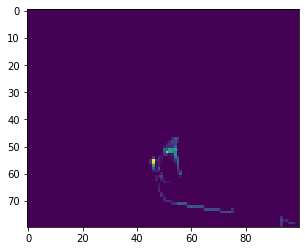

In [9]:
obs_map = agent.map2DObstacles.cpu().numpy()[0,0]
map_scale = 40
plt.figure()
plt.imshow(obs_map[200-map_scale:200+map_scale, 180-map_scale:200+map_scale])

In [ ]:
env.close()

In [ ]:
benchmark = habitat.Benchmark(args.task_config)
metrics = benchmark.evaluate(agent)
for k, v in metrics.items():
    habitat.logger.info("{}: {:.3f}".format(k, v))
    print(k, v)